### Topics

- Requests and getting webpages
- Tidying HTML
- Web Scraping with BS
    - Traversal
- simple parallelization
- Storing Snapshots by using python dill
- Exploration
- Stock selection using simple filters

### Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # pandas for dataframe based data processing and CSV file I/O

In [14]:
import requests # for http requests
from bs4 import BeautifulSoup # for html parsing and scraping
from fastnumbers import isfloat 
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 
import bs4
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tidylib import tidy_document # for tidying incorrect html

sns.set_style('whitegrid')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [4]:
def ffloat(string):
    if string is None:
        return np.nan
    if type(string)==float or type(string)==np.float64:
        return string
    if type(string)==int or type(string)==np.int64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),
                      default=np.nan)

def ffloat_list(string_list):
    return list(map(ffloat,string_list))

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string

### Requests and Getting Content
- Status code
- Getting Text Content
- Getting JSON Content
- Error Handling

#### Getting a page and its status

In [5]:
response = requests.get("http://www.example.com/", timeout=240)
response.status_code
response.content

200

b'<!doctype html>\n<html>\n<head>\n    <title>Example Domain</title>\n\n    <meta charset="utf-8" />\n    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <style type="text/css">\n    body {\n        background-color: #f0f0f2;\n        margin: 0;\n        padding: 0;\n        font-family: "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;\n        \n    }\n    div {\n        width: 600px;\n        margin: 5em auto;\n        padding: 50px;\n        background-color: #fff;\n        border-radius: 1em;\n    }\n    a:link, a:visited {\n        color: #38488f;\n        text-decoration: none;\n    }\n    @media (max-width: 700px) {\n        body {\n            background-color: #fff;\n        }\n        div {\n            width: auto;\n            margin: 0 auto;\n            border-radius: 0;\n            padding: 1em;\n        }\n    }\n    </style>    \n</head>\n\n<body>\n<div>\

#### Getting Json and parsing it

In [14]:
url = "https://jsonplaceholder.typicode.com/posts/1"
response = requests.get(url, timeout=240)
response.status_code
response.json()

content = response.json()
content.keys()

200

{'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto',
 'id': 1,
 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit',
 'userId': 1}

dict_keys(['userId', 'id', 'title', 'body'])

#### Checking Status Codes for errors

In [4]:
def request_with_check(url):
    page_response = requests.get(url, timeout=240)
    status = page_response.status_code
    if status>299:
        raise AssertionError("page content not found, status: %s"%status)
    return page_response

In [162]:
request_with_check("https://www.google.co.in/mycustom404page")

AssertionError: page content not found, status: 404

In [163]:
request_with_check("https://www.google.co.in/")

<Response [200]>

### Parsing and Traversal

- Getting body of a page and rendering it
- Inspecting Elements in Chrome
- Ways of getting element contents
- Traversals of childrens
- Getting Text and numbers
- Tables

#### Rendering HTML in Jupyter notebook

In [7]:
from IPython.core.display import HTML
HTML("<b>Rendered HTML</b>")


Here We download the page, parse using BeautifulSoup and then find the body tag content. Next we render the body tag.

In [19]:
page_response = requests.get("https://www.moneycontrol.com/india/stockpricequote/auto-2-3-wheelers/heromotocorp/HHM", timeout=240)
page_content = BeautifulSoup(page_response.content, "html.parser")
HTML(str(page_content.find("h1")))

HTML(str(page_content.find("div",attrs={'id':"content_full"})))

#### Finding elements by attributes

In [8]:
page_response = requests.get("https://www.moneycontrol.com/india/stockpricequote/auto-2-3-wheelers/heromotocorp/HHM", timeout=240)
page_content = BeautifulSoup(page_response.content, "html.parser")
price_div = page_content.find("div",attrs={"id":'b_changetext'})
HTML(str(price_div))

```python
page_content.find_all("p")
page_content.find("p",attrs={"class":"my-id"})
page_content.find_all("p",attrs={"id":"my-id"})
page_content.find_all("p",attrs={"id":"my-id"})
```

`.find` finds the first occurence.
You can check other find_* (find_next,find_previous etc)

Once you have the element you can do `.text` to get its textual content.

Like

```python
elem = page_content.find("p",attrs={"class":"my-id"})
text = elem.text
```

#### Getting Children of an element in Array

In [10]:
list(price_div.children)

[' ', <span class="gr_15 uparw_pc"><strong>46.25</strong></span>, ' (+1.41%)']

As you see the first and last element is "\n" and not actual HTML elements so we will filter them. The next function does that.

In [22]:

def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag or len(str(item).strip())>0]

In [23]:
get_children(price_div)

[<span class="gr_15 uparw_pc"><strong>46.25</strong></span>, ' (+1.41%)']

#### Parsing HTML tables and table like structures

In [169]:
html = '''
<table>
    <tr>
        <td>Month</td>
        <td>Price</td>
    </tr>
    <tr>
        <td>July</td>
        <td>2</td>
    </tr>
    <tr>
        <td>August</td>
        <td>4</td>
    </tr>
    <tr>
        <td>September</td>
        <td>3</td>
    </tr>
    <tr>
        <td>October</td>
        <td>2</td>
    </tr>
</table>

'''

html = BeautifulSoup(html,"html.parser")

In [18]:




def get_table_simple(table,is_table_tag=True):
    elems = table.find_all('tr') if is_table_tag else get_children(portfolio_table)
    table_data = list()
    for row in elems:
        
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data


        

In [171]:
get_table_simple(html)

[['Month', 'Price'],
 ['July', '2'],
 ['August', '4'],
 ['September', '3'],
 ['October', '2']]

In [172]:
html = '''
<html>
<body>
<div id="table" class="FL" style="width:210px; padding-right:10px">
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">MARKET CAP (Rs Cr)</div>
        <div class="FR gD_12">63,783.84</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">P/E</div>
        <div class="FR gD_12">17.27</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">BOOK VALUE (Rs)</div>
        <div class="FR gD_12">589.29</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">DIV (%)</div>
        <div class="FR gD_12">4750.00%</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">Market Lot</div>
        <div class="FR gD_12">1</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">INDUSTRY P/E</div>
        <div class="FR gD_12">19.99</div>
        <div class="CL"></div>
    </div>
</div>
</body>
</html>
'''

In [173]:
html, errors = tidy_fragment(html)
content = BeautifulSoup(html,"html.parser")
get_table_simple(content.find("div",attrs={"id":"table"}),is_table_tag=False)

[['MARKET CAP (Rs Cr)', '63,783.84'],
 ['P/E', '17.27'],
 ['BOOK VALUE (Rs)', '589.29'],
 ['DIV (%)', '4750.00%'],
 ['Market Lot', '1'],
 ['INDUSTRY P/E', '19.99']]

### HTML Tidying

#### Without Tidying

We remove a closing </tr> from previous html and see if BeautifulSoup can parse it correctly. Look for closing tr of July

In [174]:
html = '''
<table>
    <tr>
        <td>Month</td>
        <td>Price</td>
    </tr>
    <tr>
        <td>July</td>
        <td>2</td>
    
    <tr>
        <td>August</td>
        <td>4</td>
    </tr>
    <tr>
        <td>September</td>
        <td>3</td>
    </tr>
    <tr>
        <td>October</td>
        <td>2</td>
    </tr>
</table>

'''

content = BeautifulSoup(html,"html.parser")
get_table_simple(content)

[['Month', 'Price'],
 ['July', '2', 'August4', 'September3', 'October2'],
 ['August', '4'],
 ['September', '3'],
 ['October', '2']]

#### With Tidying

In [175]:
from tidylib import tidy_document
from tidylib import tidy_fragment
html, errors = tidy_fragment(html)
html.replace("\n","")
content = BeautifulSoup(html,"html.parser")
get_table_simple(content)

'<table>  <tr>    <td>      Month    </td>    <td>      Price    </td>  </tr>  <tr>    <td>      July    </td>    <td>      2    </td>  </tr>  <tr>    <td>      August    </td>    <td>      4    </td>  </tr>  <tr>    <td>      September    </td>    <td>      3    </td>  </tr>  <tr>    <td>      October    </td>    <td>      2    </td>  </tr></table>'

[['Month', 'Price'],
 ['July', '2'],
 ['August', '4'],
 ['September', '3'],
 ['October', '2']]

As you can see the tidying added a </tr> at the right place and we got our content parsed properly.

### Lib for fetching details

In [7]:

def get_ratios(url):
    page_response = requests.get(url, timeout=240)
    page_content, errors = tidy_document(page_response.content,options={'numeric-entities':1})
    page_content = BeautifulSoup(page_content, "html.parser")
    table_content = page_content.find_all('table',attrs={'class':'table4'})[-1]
    if "Data Not Available" in table_content.text:
         return {}
    
    table = get_table_simple(table_content)
    dates = table[2]
    rows = table[3:]
    ratios = {}
    ratios['dates'] = dates
    
    for row in rows:
        if len(row)>1:
            ratios[row[0]] = ffloat_list(row[1:])
    
    needed_keys = [('dates','ratios_dates'),
                   ('Diluted EPS (Rs.)','ratios_diluted_eps'),
                   ('Revenue from Operations/Share (Rs.)','ratios_revenue_per_share'),
                   ('PBT/Share (Rs.)','ratios_pbt_per_share'),
                   ('PBT Margin (%)','ratios_pbt_margin_per_share'),
                   ('Total Debt/Equity (X)','ratios_de'),
                   ('Asset Turnover Ratio (%)','ratios_asset_turnover_ratio'),
                   ('Current Ratio (X)','ratios_cr'),
                   ('EV/EBITDA (X)','ratios_ev_by_ebitda'),
                   ('Price/BV (X)','ratios_pb')]
    
    ratios = { your_key[1]: ratios[your_key[0]] if your_key[0] in ratios else [] for your_key in needed_keys }
    return ratios

In [8]:

def get_past_prices(sc_id):
    bse_url = "https://www.moneycontrol.com/tech_charts/bse/his/%s.csv"%sc_id
    nse_url = "https://www.moneycontrol.com/tech_charts/nse/his/%s.csv"%sc_id
    
    past_prices_nse = pd.read_csv(nse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_nse.index = pd.to_datetime(past_prices_nse.index)
    
    past_prices_bse = pd.read_csv(bse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_bse.index = pd.to_datetime(past_prices_bse.index)
    
    
    if len(past_prices_nse)>=len(past_prices_bse):
        past_prices = past_prices_nse
    else:
        past_prices = past_prices_bse
    return past_prices

In [9]:

def get_scrip_info(url,name):
    original_url = url
    key_val_pairs = {}
    key_val_pairs["original_url"] = original_url
    if not url.startswith("http"):
        url = "https://www.moneycontrol.com"+url
    try:
        page_response = requests.get(url, timeout=240)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        scrip_name = name
        price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
        name = page_content.find('h1',attrs={'class':'company_name'}).text
        
        yearly_high = page_content.find('span',attrs={'id':'n_52high'}).text.strip()
        yearly_low = page_content.find('span',attrs={'id':'n_52low'}).text.strip()
        html_data_content = page_content.find('div', attrs={'id': 'mktdet_1'})
        
        petable = get_table_simple(get_children(html_data_content)[0],is_table_tag=False)
        pbtable = get_table_simple(get_children(html_data_content)[1],is_table_tag=False)
        
        side_nav = page_content.find('dl',attrs={'id':'slider'})
        ratio_url = side_nav.find_all('dd')[2].find_all('a')[7]['href']
        ratio_url = "https://www.moneycontrol.com"+ratio_url
        ratios = get_ratios(ratio_url)
        
        
        volume = ffloat(page_content.find('span',attrs={'id':'nse_volume'}).text)
        
        sc_id = page_content.find('input',attrs={'id':'sc_id'}).get('value').lower()
        
        key_val_pairs = {**key_val_pairs, **ratios}
        
        past_prices = get_past_prices(sc_id)
        
        data_table = list()
        data_table.extend(petable)
        data_table.extend(pbtable)
        

        for row in data_table:
            k = row[0]
            if len(row)<2:
                v=None
            else:
                v = row[1].split(" ")[0].replace(',','')
            key_val_pairs[k]=v

        

        key_val_pairs["pe"] = ffloat(key_val_pairs.pop('P/E'))
        key_val_pairs["book_value"] = ffloat(key_val_pairs.pop('BOOK VALUE (Rs)'))
        key_val_pairs["deliverables"] = ffloat(key_val_pairs.pop('DELIVERABLES (%)'))
        key_val_pairs["eps"] = ffloat(key_val_pairs.pop('EPS (TTM)'))
        key_val_pairs["industry_pe"] = ffloat(key_val_pairs.pop('INDUSTRY P/E'))
        if 'MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('MARKET CAP (Rs Cr)')
        elif '**MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('**MARKET CAP (Rs Cr)')
        key_val_pairs["market_cap"] = ffloat(key_val_pairs["market_cap"])
        key_val_pairs["pb"] = ffloat(key_val_pairs.pop('PRICE/BOOK'))
        key_val_pairs["pc"] = ffloat(key_val_pairs.pop('P/C'))
        key_val_pairs['price'] = ffloat(price)
        key_val_pairs['volume'] = volume
        key_val_pairs["name"] = name
        key_val_pairs["scrip_name"] = scrip_name
        key_val_pairs["yearly_low"] = ffloat(yearly_low)
        key_val_pairs["yearly_high"] = ffloat(yearly_high)

        key_val_pairs['past_prices'] = past_prices
        key_val_pairs['de'] = np.nan
        key_val_pairs['ev_by_ebitda'] = np.nan
        if "ratios_ev_by_ebitda" in key_val_pairs and len(key_val_pairs["ratios_ev_by_ebitda"])>0:
            key_val_pairs['ev_by_ebitda'] = key_val_pairs["ratios_ev_by_ebitda"][0]
        
        if "ratios_de" in key_val_pairs and len(key_val_pairs["ratios_de"])>0:
            key_val_pairs['de'] = key_val_pairs["ratios_de"][0]
        key_val_pairs['failure'] = False

        del key_val_pairs['DIV (%)']
        del key_val_pairs['DIV YIELD.(%)']
        del key_val_pairs['FACE VALUE (Rs)']
        del key_val_pairs['Market Lot']
    except Exception as e:
        key_val_pairs['failure'] = True
        key_val_pairs['err'] = "Error for: %s"%original_url
        print(key_val_pairs['err'])
        return key_val_pairs
        
    return key_val_pairs


In [16]:
def get_scrip_info_by_nse_name(nse_name):
    url = "https://www.moneycontrol.com/mccode/common/autosuggesion.php?classic=true&query=%s&type=1&format=json"%nse_name
    page_response = requests.get(url, timeout=240)
    json_text = page_response.text
    data = json.loads(json_text)
    if len(data)>1:
        scrips = pd.DataFrame.from_records(data)["pdt_dis_nm"].values
        idx = list(map(lambda x:BeautifulSoup(x, "html.parser").find("span").text.split(",")[1].strip(),scrips)).index(nse_name)
        scrip_url = data[idx]['link_src']
    else:
        scrip_url = data[0]['link_src']
    return get_scrip_info(scrip_url,nse_name)

### Company Analysis and Filtering 



#### Generic Filter one variable upper lower limits

In [11]:
def get_generic_filter(param_name,lower_limit=None,upper_limit=None,
                                     replacement_nan=None,replacement_not_present=None):
    def filter_fn(stock_detail):
        param = replacement_not_present
        if param_name in stock_detail:
            param = ffloat(stock_detail[param_name])
            
        if np.isnan(param):
            param = replacement_nan
        
        if param is None or np.isnan(param):
            return False
        
        if param<=upper_limit and param>=lower_limit:
            return True
        return False
        
    return filter_fn

In [14]:
def get_all_company_details(nse_names,
                            threadpool_size=8):
    batch_size = 5*threadpool_size
    pool = ThreadPool(threadpool_size)
    scrip_details = pool.map(get_scrip_info_by_nse_name, nse_names)
    failures = list(filter(lambda x:x['failure'],scrip_details))
    successes = list(filter(lambda x:not x['failure'],scrip_details))
    successes={scrip['scrip_name']:scrip for scrip in successes}
    return successes,failures


In [55]:
some_nse_companies = ["AARTIDRUGS","ATUL","AUROPHARMA","BAJAJ-AUTO","BANKBARODA",
                     "DBCORP","DIVISLAB","EVEREADY","EICHERMOT",
                     "GLENMARK","GREAVESCOT","HDFCBANK","ITC","KOTAKBANK","KEC"]
successes,failures = get_all_company_details(some_nse_companies,
                        threadpool_size=4);

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [56]:
len(successes.keys())
len(failures)

15

0

#### Write to File

In [57]:

import dill
with open('tutorial_results.pkl', 'wb') as f:
    dill.dump(successes, f)
    dill.dump(failures, f)

#### Read from File 

In [2]:
import dill
with open('tutorial_results.pkl', 'rb') as f:
    successes = dill.load(f)
    failures = dill.load(f)

### Portfolio Selection based on Data

In [24]:
def filter_companies(all_scrips,filters=[]):
    scrip_details = list(all_scrips.values())
    
    for i in range(len(filters)):
        scrip_details = list(filter(filters[i],scrip_details))
    
    return scrip_details
    
    

In [27]:
def get_df_from_scrip_details(scrip_details):
    other_cols = ['name','scrip_name']
    numeric_cols = ['price', 
                    'market_cap', 'pb', 'pe','de']
    
    
    all_cols = other_cols+numeric_cols
    scrip_details = [{ your_key: scrip[your_key] for your_key in all_cols } for scrip in scrip_details]
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details

In [58]:
pe_filter = get_generic_filter("pe",lower_limit=0,upper_limit=20,
                                     replacement_nan=-1,replacement_not_present=-1)
pb_filter = get_generic_filter("pb",lower_limit=0,upper_limit=4,
                                     replacement_nan=-1,replacement_not_present=-1)
filtered_companies = filter_companies(successes,filters=[pe_filter,pb_filter])
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,price,market_cap,pb,pe,de
0,Aarti Drugs Ltd.,AARTIDRUGS,551.15,1300.08,3.00,17.71,1.11
1,Aurobindo Pharma Ltd.,AUROPHARMA,610.90,35749.15,3.58,19.72,0.37
2,Bajaj Auto Ltd.,BAJAJ-AUTO,2629.70,76139.70,3.99,17.88,0.00
3,DB Corp Ltd.,DBCORP,254.65,4700.99,2.43,15.08,0.02
4,Glenmark Pharma Ltd.,GLENMARK,591.05,16591.49,1.60,16.36,0.29
5,Greaves Cotton Ltd.,GREAVESCOT,157.10,3830.38,3.99,18.90,NaN
6,KEC International Ltd.,KEC,301.40,7743.50,3.80,17.61,0.63


In [59]:
de_filter = get_generic_filter("de",lower_limit=0,upper_limit=0.5,
                                     replacement_nan=0,replacement_not_present=0)
filtered_companies = filter_companies(successes,filters=[pe_filter,pb_filter,de_filter])
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,price,market_cap,pb,pe,de
0,Aurobindo Pharma Ltd.,AUROPHARMA,610.90,35749.15,3.58,19.72,0.37
1,Bajaj Auto Ltd.,BAJAJ-AUTO,2629.70,76139.70,3.99,17.88,0.00
2,DB Corp Ltd.,DBCORP,254.65,4700.99,2.43,15.08,0.02
3,Glenmark Pharma Ltd.,GLENMARK,591.05,16591.49,1.60,16.36,0.29
4,Greaves Cotton Ltd.,GREAVESCOT,157.10,3830.38,3.99,18.90,NaN


Below we see which filter passed and failed for different companies. This will help us understand why certain companies were rejected by our filtering process earlier.

In [35]:
def score_company_on_filters(all_scrips,filters={}):
    all_scrips = list(all_scrips.values())
    other_cols = ['name','scrip_name']
    numeric_cols = ['price','market_cap', 'pb', 'pe','de']
    all_cols = other_cols+list(filters.keys())+numeric_cols
    scrip_details = []
    for scrip in all_scrips:
        for key in filters.keys():
            scrip[key] = filters[key](scrip)
        scrip_detail = { your_key: scrip[your_key] for your_key in all_cols }
        
        scrip_details.append(scrip_detail)
        
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details
    

In [60]:
scores_df = score_company_on_filters(successes,filters={"pe_filter":pe_filter,"pb_filter":pb_filter,"de_filter":de_filter})

In [61]:
scores_df

,name,scrip_name,pe_filter,pb_filter,de_filter,price,market_cap,pb,pe,de
0,Aarti Drugs Ltd.,AARTIDRUGS,True,True,False,551.15,1300.08,3.00,17.71,1.11
1,Atul Ltd.,ATUL,False,False,True,3078.70,9180.90,4.18,28.68,0.00
2,Aurobindo Pharma Ltd.,AUROPHARMA,True,True,True,610.90,35749.15,3.58,19.72,0.37
3,Bajaj Auto Ltd.,BAJAJ-AUTO,True,True,True,2629.70,76139.70,3.99,17.88,0.00
4,Bank Of Baroda,BANKBARODA,False,True,True,148.30,39233.00,0.90,NaN,NaN
5,DB Corp Ltd.,DBCORP,True,True,True,254.65,4700.99,2.43,15.08,0.02
6,Divis Laboratories Ltd.,DIVISLAB,False,False,True,1124.30,29719.21,4.99,30.99,0.01
7,Eveready Industries India Ltd.,EVEREADY,False,False,False,239.65,1744.49,5.07,29.30,0.55
8,Eicher Motors Ltd.,EICHERMOT,False,False,True,28997.70,79101.31,14.72,46.18,0.02
9,Glenmark Pharma Ltd.,GLENMARK,True,True,True,591.05,16591.49,1.60,16.36,0.29


### Plotting and Analysis

#### PE vs MarketCap Corr

(10, 40)

(0, 600000.0)

Text(0.5,0,'PE Ratio')

Text(0,0.5,'Market Cap in Crores (10 Million INR.)')

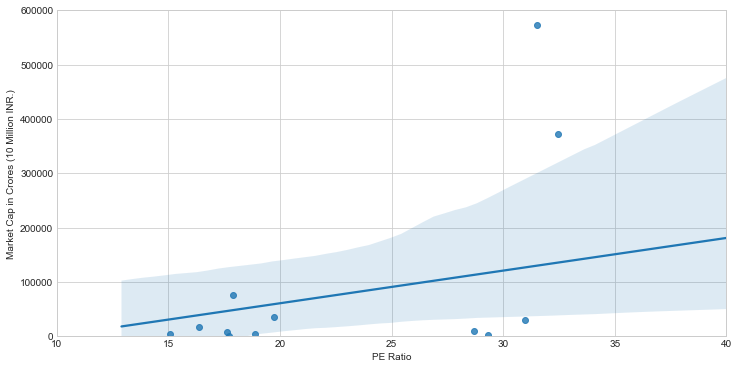

Text(0,0.5,'PE Ratio')

Text(0.5,0,'Market Cap in Crores (10 Million INR.)')

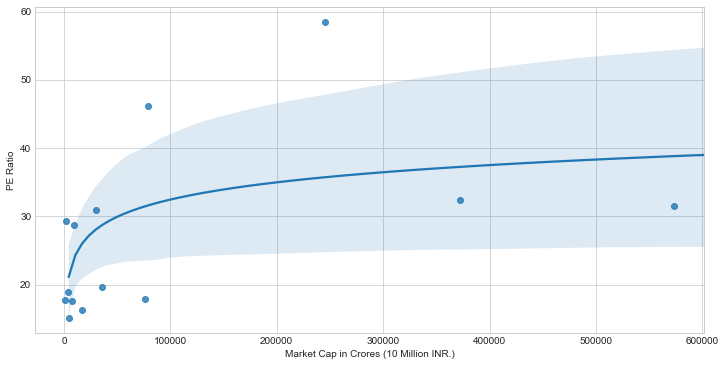

In [66]:
pe_list = []
mcap_list = []
for key in successes.keys():
    prices_df = successes[key]['past_prices']
    
    pe = successes[key]['pe']
    mcap = successes[key]['market_cap']
    
    pe_list.append(pe)
    mcap_list.append(mcap)
    
plt.figure(figsize=(12,6))
ax = sns.regplot(x=np.array(pe_list), y=np.array(mcap_list),fit_reg=True)
ax.set_xlim([10,40])
ax.set_ylim([0,6e5])
plt.xlabel("PE Ratio");
plt.ylabel("Market Cap in Crores (10 Million INR.)");

plt.show()
plt.figure(figsize=(12,6))
ax = sns.regplot(x=np.array(mcap_list), y=np.array(pe_list),fit_reg=True,logx=True)
plt.ylabel("PE Ratio");
plt.xlabel("Market Cap in Crores (10 Million INR.)");
plt.show()

#### Price Volume Charts

In [52]:
def generate_price_chart(stock_df,name,days=1095,ewmas=[],other_technical_indicators=[]):
    plt.figure(figsize=(16,8))
    ts_df = stock_df.tail(days)
    handles = []
    p1, = plt.plot(ts_df.index, ts_df['close'],label="price")
    handles.append(p1)
    for ewma in ewmas:
        y = ts_df['close'].ewm(span=ewma).mean()
        p2, = plt.plot(ts_df.index, y,label="%s day ewma"%ewma)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title(name)
    plt.ylabel('Closing Price')
    plt.show()

In [51]:

def generate_price_volume_chart(stock_df,name,days=1095,ewmas=[],other_technical_indicators=[]):
    plt.figure(figsize=(16,8))
    top = plt.subplot2grid((6,6), (0, 0), rowspan=4, colspan=6)
    bottom = plt.subplot2grid((6,6), (4,0), rowspan=2, colspan=6)
    ts_df = stock_df.tail(days)
    handles = []
    p1, = top.plot(ts_df.index, ts_df['close'],label="price")
    handles.append(p1)
    for ewma in ewmas:
        y = ts_df['close'].ewm(span=ewma).mean()
        p2, = top.plot(ts_df.index, y,label="%s day ewma"%ewma)
        handles.append(p2)
    top.legend(handles=handles)
    bottom.bar(ts_df.index, ts_df['volume']) 
    bottom.set_ylim([ts_df['volume'].min(),ts_df['volume'].max()])
    top.axes.get_xaxis().set_visible(False)
    top.set_title(name)
    top.set_ylabel('Closing Price')
    bottom.set_ylabel('Volume')
    
    plt.show()

In [70]:
hero = get_scrip_info_by_nse_name('HEROMOTOCO')
exide = get_scrip_info_by_nse_name('EXIDEIND')

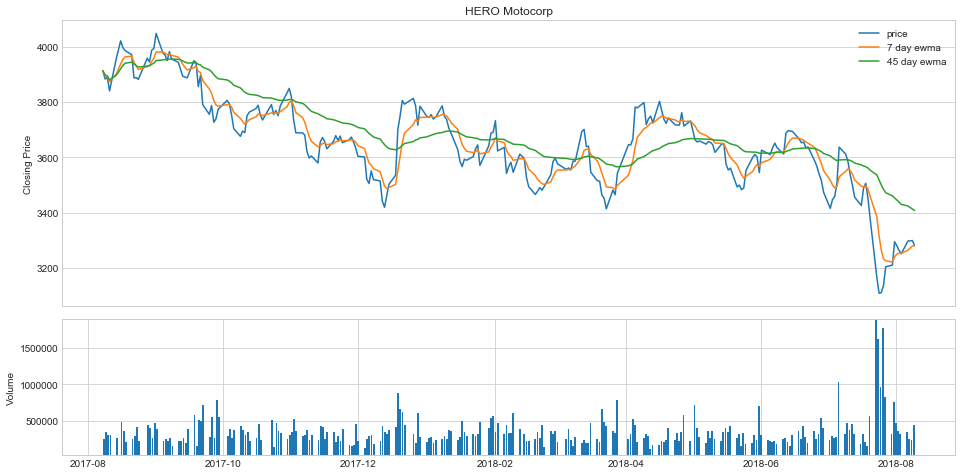

In [71]:
generate_price_volume_chart(hero['past_prices'],"HERO Motocorp",days=252,ewmas=[7,45])

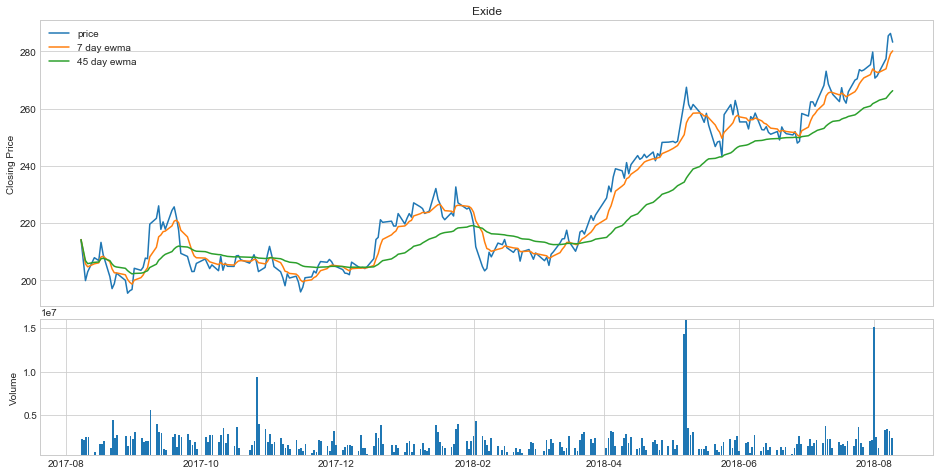

In [72]:
generate_price_volume_chart(exide['past_prices'],"Exide",days=252,ewmas=[7,45])


#### Returns analysis

In [76]:

def generate_returns_chart(stocks,days=252):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).apply(lambda x: x / x[0]) for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title("Comparative returns")
    plt.ylabel('Comparative Returns')
    
    plt.show()

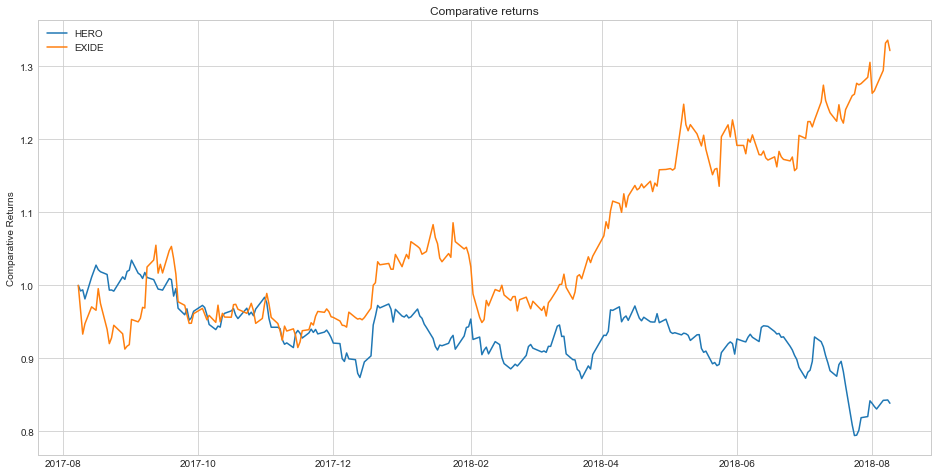

In [73]:
generate_returns_chart({"HERO":hero['past_prices'],
                       "EXIDE":exide['past_prices']})

#### Volatility analysis

In [74]:
def generate_percent_change_chart(stocks,days=252):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).pct_change()*100 for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        stocks[key]['name'] = key
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    all_stocks = pd.concat(list(stocks.values()))
    plt.legend(handles=handles)
    plt.title("Daily Percent Changes Chart")
    plt.ylabel('Daily Percent Changes')
    plt.show()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(x="name", y="close", data=all_stocks,ax=ax);
    ax.xaxis.set_tick_params(rotation=90)
    plt.show()

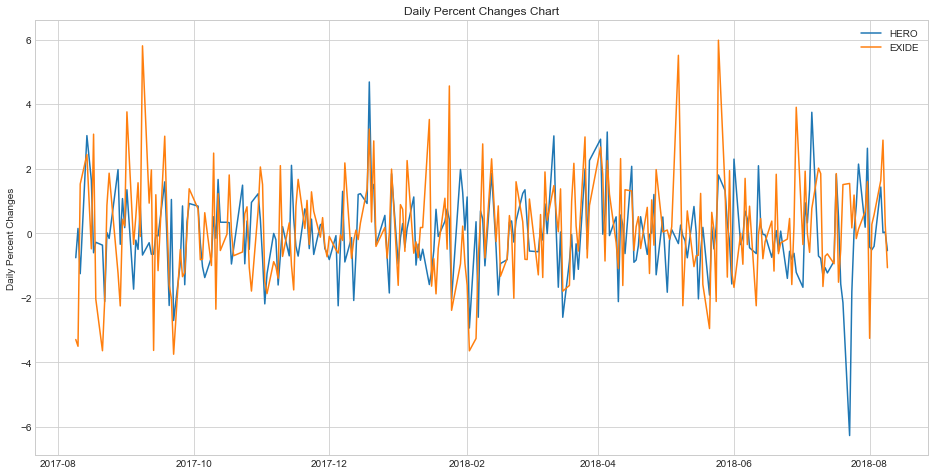

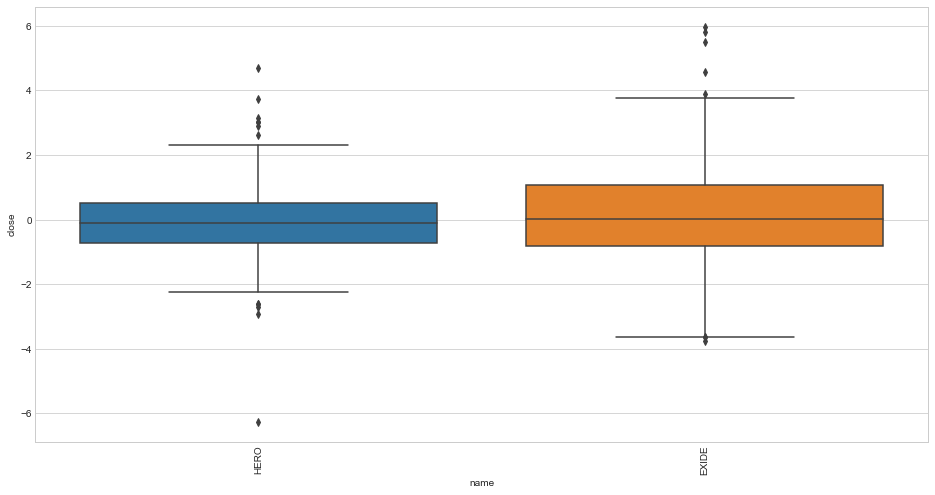

In [75]:

generate_percent_change_chart({"HERO":hero['past_prices'],
                       "EXIDE":exide['past_prices']},days=252)

#### Returns and Volatility of all companies we used

In [77]:
all_scrip_prices_df = {scrip["scrip_name"]:scrip['past_prices'] for scrip in successes.values()}


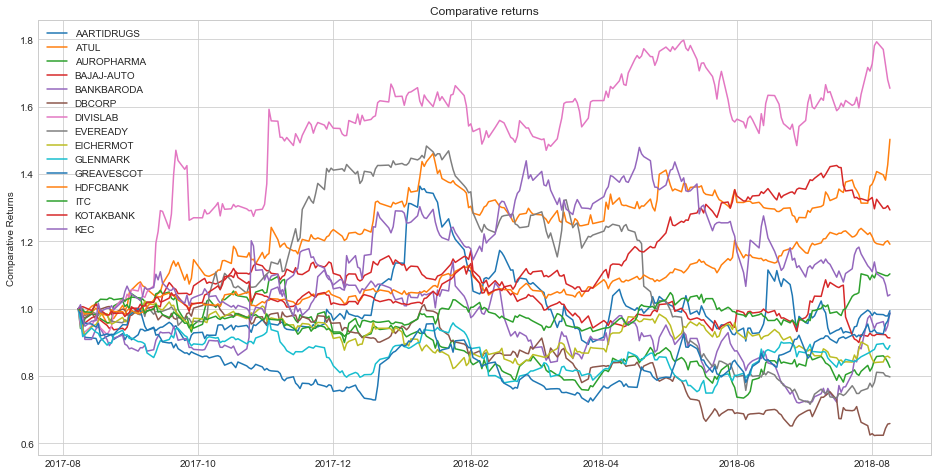

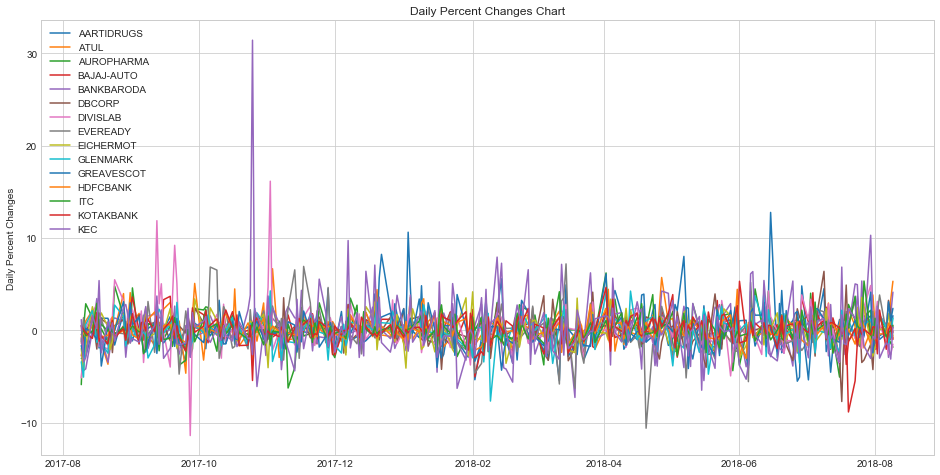

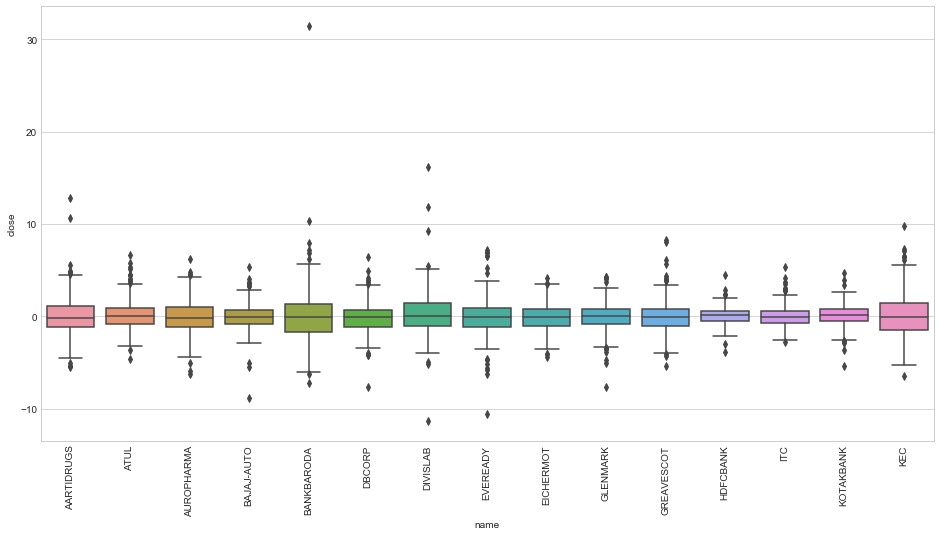

In [78]:
generate_returns_chart(all_scrip_prices_df)
generate_percent_change_chart({scrip["scrip_name"]:scrip['past_prices'] for scrip in successes.values()})

#### Nifty 50, Nifty 100, Nifty midcap 50 Analysis

In [20]:
n50_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty.csv"
n50 = pd.read_csv(n50_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n50.index = pd.to_datetime(n50.index)


n100_url = "http://www.moneycontrol.com/tech_charts/nse/his/cnx_100.csv"
n100 = pd.read_csv(n100_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n100.index = pd.to_datetime(n100.index)

nmid_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty_midcap_50.csv"
nmid = pd.read_csv(nmid_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
nmid.index = pd.to_datetime(nmid.index)




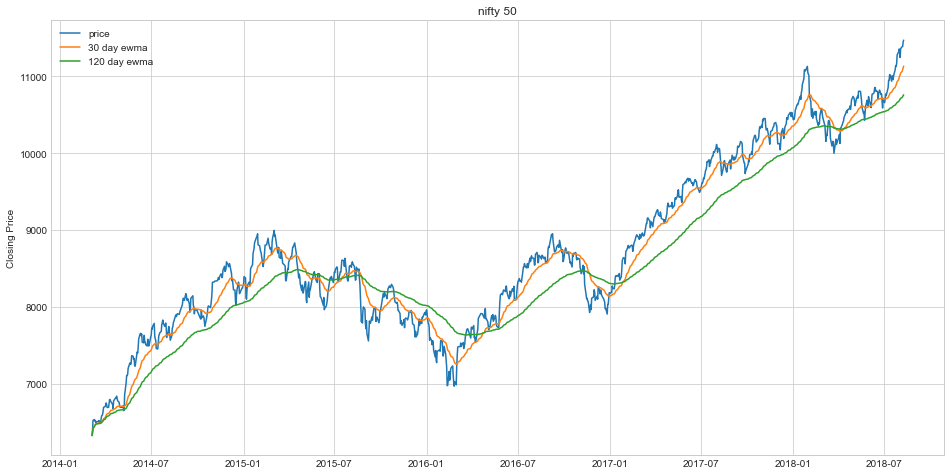

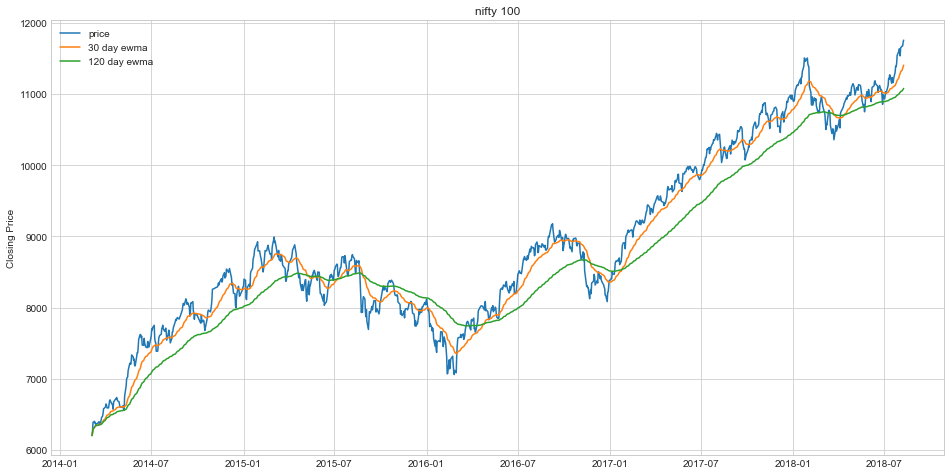

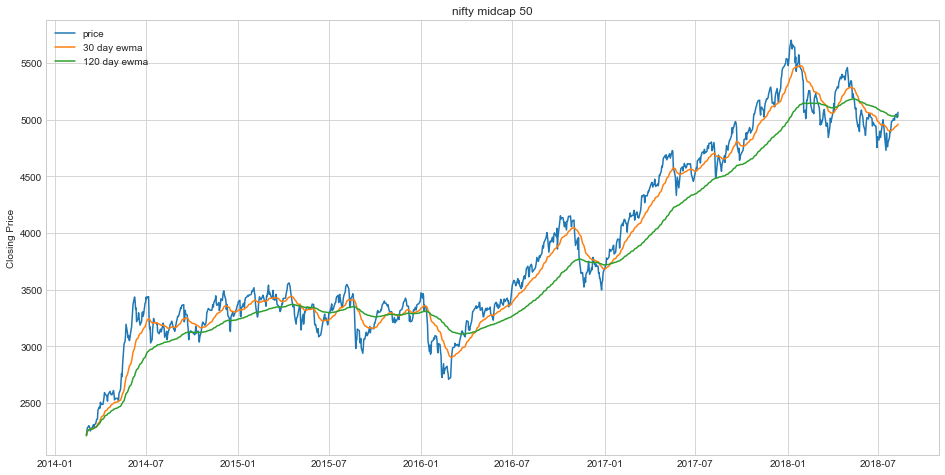

In [23]:

generate_price_chart(n50,"nifty 50",days=1095,ewmas=[30,120])
generate_price_chart(n100,"nifty 100",days=1095,ewmas=[30,120])
generate_price_chart(nmid,"nifty midcap 50",days=1095,ewmas=[30,120])


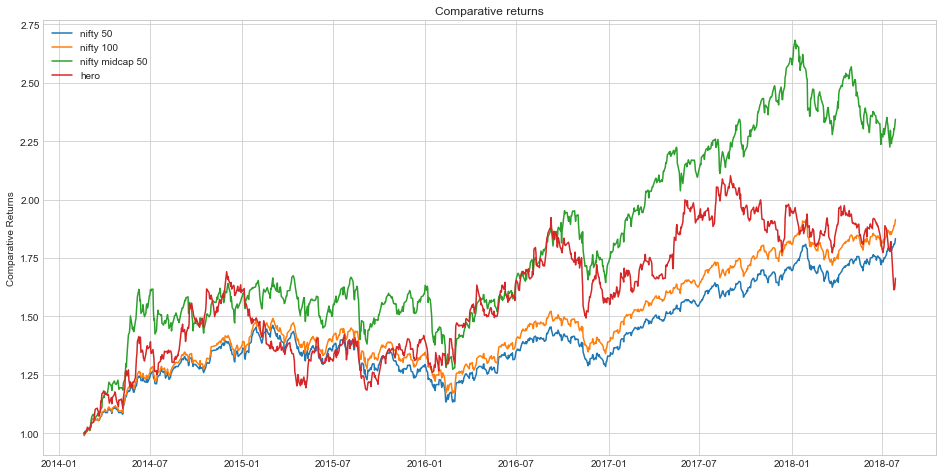

In [80]:
generate_returns_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid,"hero":hero['past_prices']['all_past_prices']})

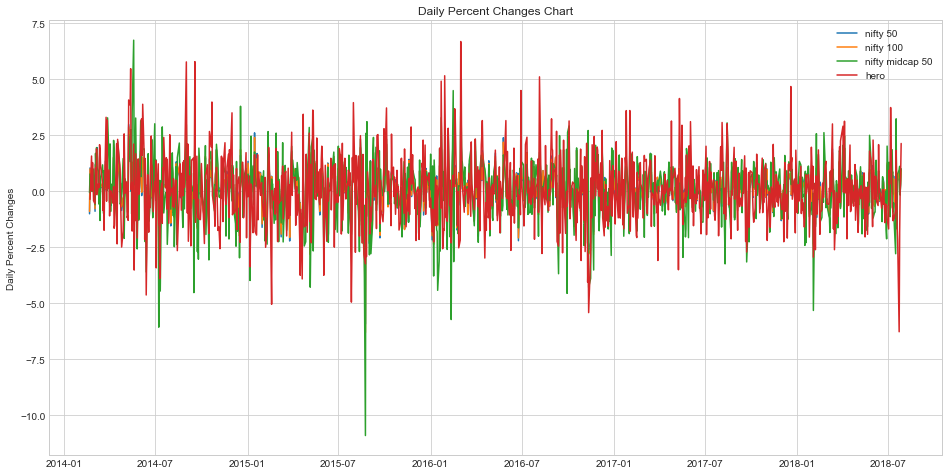

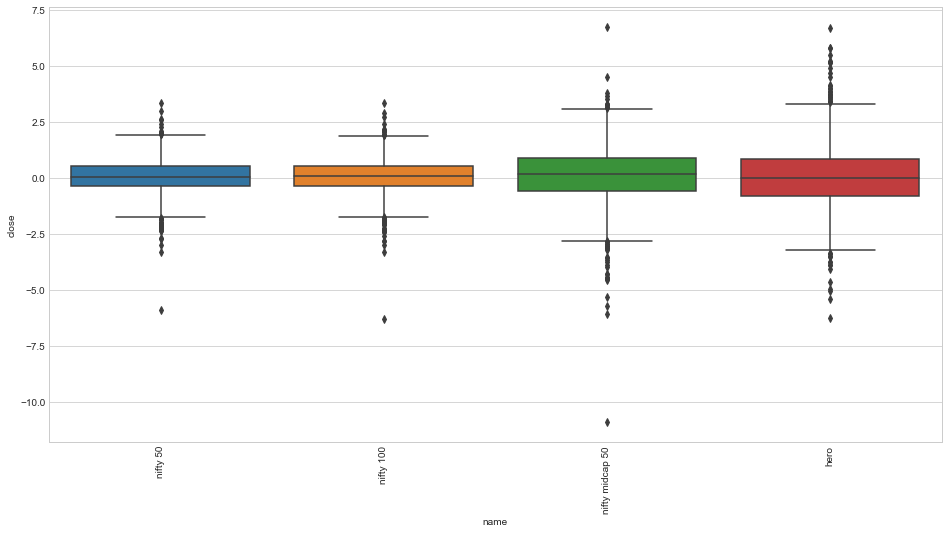

In [79]:



generate_percent_change_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid,"hero":hero['past_prices']['all_past_prices']},days=1095)


### References

- https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
- https://mapattack.wordpress.com/2017/02/14/python-for-stocks-2/

more involved articles:

 - https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/
 - https://nextjournal.com/hisham/stock-market
 